# Implementing A GPT-model From Scratch

- Coding a GPT-like LLM that can be trained to generate uman-like text.
- Normalizing layer activations to stabilize NN training.
- Adding `shortcut connections` to train deep NNs effectively.
- Implementing transformer blocks to create GPT models of various sizes.
- Computing the number of parameters and storage requiremnts of GPT models.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [4]:
GPT_CONFIG_124M: dict[str, Any] = {
    "vocab_size": 50_257,
    "context_length": 1_024,
    "emb_dim": 768,
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,
}

### A Placeholder GPT Backbone


<img src="./images/ch04__gpt-model.png" width="600">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/167)

In [5]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg: dict[str, Any]) -> None:
        super().__init__()

        # Lookup tables
        self.tok_emb = nn.Embedding(cfg.get("vocab_size"), cfg.get("emb_dim"))
        self.pos_emb = nn.Embedding(cfg.get("context_length"), cfg.get("emb_dim"))
        self.drop_emb = nn.Dropout(cfg.get("drop_rate"))
        self.transformer_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg.get("n_layers"))]
        )

        self.final_norm = DummyLayerNorm(cfg.get("emb_dim"))
        self.out_head = nn.Linear(cfg.get("emb_dim"), cfg.get("vocab_size"), bias=False)

    def forward(self, x: Tensor) -> Tensor:
        batch_size, seq_len = x.shape
        tok_embeds: Tensor = self.tok_emb(x)
        pos_embeds: Tensor = self.pos_emb(torch.arange(seq_len, device=x.device))
        # Add token and positional embeddings to get input embeddings
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits: Tensor = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg: dict[str, Any]) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, cfg: dict[str, Any]) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return x

### Overview

<img src="./images/ch04_mental_.gpt_pic.png" alt="gpt" width="600">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/36)

In [6]:
# Tokenize a batch consisting of sample texts.
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
text1: str = "Every effort moves you"
text2: str = "Everyday holds a"
batch: list[int] = []

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch_tensor: Tensor = torch.stack(batch, dim=0)

print(f"Shape of batch_tensor: {tuple(batch_tensor.shape)}\n")
print(f"Batch_tensor: \n{batch_tensor}\n")

Shape of batch_tensor: (2, 4)

Batch_tensor: 
tensor([[6109, 3626, 6100,  345],
        [6109,  820, 6622,  257]])



In [7]:
# Instantiate the DummyGPTModel
seed: int = 5
torch.manual_seed(seed)

model = DummyGPTModel(GPT_CONFIG_124M)
logits: Tensor = model(batch_tensor)

print(f"Shape of logits: {tuple(logits.shape)}\n")
print(f"logits: \n{logits}\n")

Shape of logits: (2, 4, 50257)

logits: 
tensor([[[ 0.5533, -0.7479,  0.4139,  ..., -0.0574,  0.6204, -2.5507],
         [-1.1735, -0.2195,  1.0402,  ..., -0.7333, -0.7077, -0.3804],
         [-1.9239,  1.1349, -0.0109,  ..., -0.3656,  1.0079,  0.4062],
         [-0.7575,  1.7710, -0.6395,  ...,  0.6653,  1.6365, -0.8927]],

        [[ 0.5858, -0.8553,  0.9740,  ...,  0.0096,  0.8599, -2.1585],
         [-0.1176, -0.3691,  1.7665,  ..., -0.4001, -1.3405,  0.5952],
         [-0.6279,  1.0642,  1.5218,  ...,  0.7092,  2.9929,  0.1296],
         [-0.3761,  0.5712, -1.1901,  ...,  2.1124,  0.4384,  0.2881]]],
       grad_fn=<UnsafeViewBackward0>)



### Comment

- The output (2, 4, 50_257) has `2` rows corresponding to the `number of input data`.
- It has `4` rows which is the `context length` of the input and `50_257` is the number of unique words (`vocab_size`) in the input.

### Normalizing Activations With Layer Normalization

- Layer  normalization is used to improve the stability and efficiency of neural networks.
- It aims to to adjust the activations at the output of a NN layer to have a mean of 0 and a standard deviation of 1.
- These adjustments speed up the convergence to effective weights and ensures consistent, reliable training.

<br>

<img src="./images/ch04_norm_layer.png" width="600">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/52)

<br><hr>

#### Layer Norm vs Batch Norm

- Batch norm normalizes across the batch dimension, whereas layer norm normalizes across the feature/channel dimension.
- Layer norm is preferred because it normalizes each input independently of the batch size and it's more efficient and stable.

In [8]:
torch.manual_seed(seed)

batch_tensor: Tensor = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out: Tensor = layer(batch_tensor)
print(f"out: \n{out}\n")

mean: Tensor = out.mean(dim=-1, keepdim=True)
variance: Tensor = out.var(dim=-1, unbiased=False, keepdim=True)
print("===== Before Layer Normalization ===== \n")
print(f"mean: \n{mean}\n\nvariance: \n{variance}\n")

out: 
tensor([[0.7336, 0.0000, 0.3491, 0.0000, 0.5753, 0.0000],
        [1.0493, 0.0000, 0.0000, 0.0000, 0.6904, 0.5885]],
       grad_fn=<ReluBackward0>)

===== Before Layer Normalization ===== 

mean: 
tensor([[0.2763],
        [0.3880]], grad_fn=<MeanBackward1>)

variance: 
tensor([[0.0888],
        [0.1701]], grad_fn=<VarBackward0>)



In [9]:
# Normalize the output
out_norm: Tensor = (out - mean) / torch.sqrt(variance)
mean_1: Tensor = out_norm.mean(dim=-1, keepdim=True)
variance_1: Tensor = out_norm.var(dim=-1, unbiased=False, keepdim=True)
print(f"out_norm: \n{out_norm}\n")
print("===== After Layer Normalization ===== \n")
print(f"mean: \n{mean_1}\n\nvariance: \n{variance_1}\n")

out_norm: 
tensor([[ 1.5345, -0.9273,  0.2441, -0.9273,  1.0031, -0.9273],
        [ 1.6033, -0.9408, -0.9408, -0.9408,  0.7331,  0.4861]],
       grad_fn=<DivBackward0>)

===== After Layer Normalization ===== 

mean: 
tensor([[-2.9802e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)

variance: 
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)



In [10]:
# Improve readability
torch.set_printoptions(sci_mode=False)
print("===== After Layer Normalization ===== \n")
print(f"mean: \n{mean_1}\n\nvariance: \n{variance_1}\n")

===== After Layer Normalization ===== 

mean: 
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)

variance: 
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)



In [11]:
class LayerNorm(nn.Module):
    def __init__(self, embed_dim: int) -> None:
        super().__init__()

        self.eps: float = 1e-5  # Prevents zero division

        # Trainable params that's automatically adjusted by the LLM during
        # training to improve model performance
        self.scale = nn.Parameter(torch.ones(embed_dim))
        self.shift = nn.Parameter(torch.zeros(embed_dim))

    def forward(self, x: Tensor) -> Tensor:
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, unbiased=False, keepdim=True)
        norm_x: Tensor = (x - mean) / (std + self.eps)

        return (self.scale * norm_x) + self.shift

In [12]:
layer_norm = LayerNorm(embed_dim=5)
out_layer_norm: Tensor = layer_norm(batch_tensor)

mean: Tensor = out_layer_norm.mean(dim=-1, keepdim=True)
variance: Tensor = out_layer_norm.var(dim=-1, unbiased=False, keepdim=True)
print(f"out_layer_norm: \n{out_layer_norm}\n")
print("===== After Layer Normalization ===== \n")
print(f"mean: \n{mean}\n\nvariance: \n{variance}\n")

out_layer_norm: 
tensor([[-0.5305, -0.7778, -0.6812,  1.9086,  0.0809],
        [ 1.6684, -1.0660, -0.5434,  0.5961, -0.6551]], grad_fn=<AddBackward0>)

===== After Layer Normalization ===== 

mean: 
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)

variance: 
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)



<hr>

### Implementing GELU (Gaussian Error Linear Unit)

- **Smoothness**: Unlike ReLU's sharp cutoff at zero, `GELU` has a smoother gradient transition. This smoothness helps with training, as optimization algorithms can navigate the function's landscape more effectively.

- **Non-zero gradients**: ReLU outputs zero for negative inputs, killing the gradient and hindering learning in those regions. `GELU` maintains non-zero gradients even for negative inputs, allowing the network to learn from a wider range of data. i.e. neurons with -ve gradients can still contribute to the learning process.

#### Note

- **Computational cost**: The original `GELU` formulation can be computationally expensive. Luckily, there are efficient approximations that retain the benefits without the high cost.

<!-- [![image.png](https://i.postimg.cc/9XSGKNZ9/image.png)](https://postimg.cc/14GnNBWR) -->
[![image.png](https://i.postimg.cc/pTrF1Ddk/image.png)](https://postimg.cc/wyKM1RLs)

$$GELU(x) = 0.5x * ( 1 + tanh( \sqrt{\frac{2}{\pi}} * (x + 0.044715x^{3}) ) ) $$

In [13]:
class GELU(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        gelu: Tensor = (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )
        return gelu


class FeedForward(nn.Module):
    """Applies a feed-forward neural network to the input tensor `x`. The feed-forward network
    consists of two linear layers with a GELU activation in between. The first linear layer
    expands the input dimension by a factor of 4, and the second linear layer projects the result
    back to the original input dimension.

    Args:
        x (torch.Tensor): The input tensor to be passed through the feed-forward network.

    Returns:
        torch.Tensor: The output tensor after passing through the feed-forward network.
    """

    def __init__(self, cfg: dict[str, Any]) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(cfg.get("emb_dim"), 4 * cfg.get("emb_dim")),
            GELU(),
            nn.Linear(4 * cfg.get("emb_dim"), cfg.get("emb_dim")),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.layers(x)

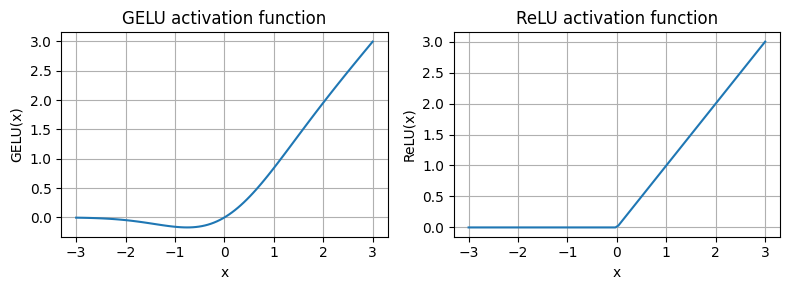

In [14]:
gelu, relu = GELU(), nn.ReLU()

x: Tensor = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
torch.manual_seed(seed)

ff_network = FeedForward(cfg=GPT_CONFIG_124M)
x: Tensor = torch.randn(2, 3, 768)
out: Tensor = ff_network(x)

print(f"out: {out.shape}")
print(f"out: \n{out}")

out: torch.Size([2, 3, 768])
out: 
tensor([[[-0.0818,  0.1450, -0.2439,  ...,  0.1561, -0.2144, -0.1624],
         [-0.0185, -0.1845, -0.0458,  ..., -0.2349,  0.0994, -0.1877],
         [ 0.0208, -0.0388, -0.3768,  ...,  0.0683,  0.0194, -0.1743]],

        [[ 0.2472, -0.2242, -0.1187,  ...,  0.1411,  0.3364,  0.0805],
         [-0.2056, -0.1560, -0.2990,  ...,  0.0214,  0.1276, -0.2477],
         [ 0.1175,  0.1580, -0.2499,  ...,  0.0499,  0.1570, -0.0417]]],
       grad_fn=<ViewBackward0>)


#### Feed Forward Network With GELU

<img src="./images/ch04__ffn.png" width="600">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/112)

### Shortcut Connections

- AKA Skip/Residual connections.
- Shortcut Connections involve adding the output of one layer to the input of the next layer.
- It mitigates the vanishing gradient problem.

<img src="./images/ch04__shortcut.png" width="600">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/119)

In [16]:
class ExampleDeepNeuralNetwork_v1(nn.Module):
    def __init__(self, layer_sizes: list[int], use_shortcut: bool = True):
        super().__init__()

        self.use_shortcut = use_shortcut
        assert len(layer_sizes) == 6, "layer_sizes must be of length 6"
        self.layers = nn.ModuleList(
            [
                # 5 layers
                nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output: Tensor = layer(x)
            # Check if shortcut connections can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                # Apply the shortcut connection
                x = x + layer_output
            else:
                # Otherwise, just use the layer output
                x = layer_output
        return x


def print_gradients(model: nn.Module, x: Tensor) -> None:
    """This is used to print the gradients of the model."""
    # Forward pass
    output: Tensor = model(x)
    target: Tensor = torch.tensor([[0.0]])

    # Calculate the loss
    criterion = nn.MSELoss()
    loss: Tensor = criterion(output, target)

    # Backward pass
    loss.backward()

    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item():.6f}")

In [17]:
[f"Linear({idx}, {idx + 1})" for idx in range(6 - 1)]

['Linear(0, 1)',
 'Linear(1, 2)',
 'Linear(2, 3)',
 'Linear(3, 4)',
 'Linear(4, 5)']

In [18]:
torch.manual_seed(seed)

layer_sizes: list[int] = [3, 3, 3, 3, 3, 1]
sample_input: Tensor = torch.tensor([[1.0, 0.0, -1.0]])

model_wfout_shortcut = ExampleDeepNeuralNetwork_v1(
    layer_sizes=layer_sizes, use_shortcut=False
)
print(f"input: {sample_input.shape}")

model_wfout_shortcut

input: torch.Size([1, 3])


ExampleDeepNeuralNetwork_v1(
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): GELU()
    )
    (4): Sequential(
      (0): Linear(in_features=3, out_features=1, bias=True)
      (1): GELU()
    )
  )
)

In [19]:
print_gradients(model=model_wfout_shortcut, x=sample_input)

layers.0.0.weight has gradient mean of 0.000290
layers.1.0.weight has gradient mean of 0.000209
layers.2.0.weight has gradient mean of 0.000293
layers.3.0.weight has gradient mean of 0.000627
layers.4.0.weight has gradient mean of 0.006588


In [20]:
class ExampleDeepNeuralNetwork_v2(nn.Module):
    def __init__(self, layer_sizes: list[int], use_shortcut: bool = True):
        super().__init__()

        self.use_shortcut = use_shortcut
        assert len(layer_sizes) == 6, "layer_sizes must be of length 6"
        self.layers = nn.ModuleList(
            [
                # 5 layers
                nn.Sequential(nn.Linear(layer_sizes[idx], layer_sizes[idx + 1]), GELU())
                for idx in range(len(layer_sizes) - 1)
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output: Tensor = layer(x)
            # Check if shortcut connections can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                # Apply the shortcut connection
                x = x + layer_output
            else:
                # Otherwise, just use the layer output
                x = layer_output
        return x

In [21]:
torch.manual_seed(seed)

layer_sizes: list[int] = [3, 3, 3, 3, 3, 1]
sample_input: Tensor = torch.tensor([[1.0, 0.0, -1.0]])

model_wfout_shortcut = ExampleDeepNeuralNetwork_v2(
    layer_sizes=layer_sizes, use_shortcut=False
)
print(f"input: {sample_input.shape}")
print(model_wfout_shortcut)
print()

# The weights shrink to a vanishingly small value
print_gradients(model=model_wfout_shortcut, x=sample_input)

input: torch.Size([1, 3])
ExampleDeepNeuralNetwork_v2(
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): GELU()
    )
    (4): Sequential(
      (0): Linear(in_features=3, out_features=1, bias=True)
      (1): GELU()
    )
  )
)

layers.0.0.weight has gradient mean of 0.000290
layers.1.0.weight has gradient mean of 0.000209
layers.2.0.weight has gradient mean of 0.000293
layers.3.0.weight has gradient mean of 0.000627
layers.4.0.weight has gradient mean of 0.006588


In [22]:
torch.manual_seed(seed)


model_wf_shortcut = ExampleDeepNeuralNetwork_v2(
    layer_sizes=layer_sizes,
    use_shortcut=True,  # NEW!
)
print(f"input: {sample_input.shape}")
print(model_wf_shortcut)
print()

# The weights are slightly larger than the ones without the shortcut.
print_gradients(model=model_wf_shortcut, x=sample_input)

input: torch.Size([1, 3])
ExampleDeepNeuralNetwork_v2(
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): GELU()
    )
    (4): Sequential(
      (0): Linear(in_features=3, out_features=1, bias=True)
      (1): GELU()
    )
  )
)

layers.0.0.weight has gradient mean of 0.012447
layers.1.0.weight has gradient mean of 0.005778
layers.2.0.weight has gradient mean of 0.013287
layers.3.0.weight has gradient mean of 0.009252
layers.4.0.weight has gradient mean of 0.077685


<br><br>

### Connecting Attention And Linear Layers In A Transformer Block

- Implement the transformer block.
- The transformer block in the 124 million parameter GPT-2 architecture was repeated 12 times and it combines several concepts like:
  - multi-head attention
  - layer norm, dropout
  - feedforward layers
  - and GELU activations.

<br>

<img src="./images/ch04__trnsf_block.png" width="600">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/145)

<br>

- When a transformer block processes an input sequence, each element in the sequence is represented by a fixed-size vector.
- The operations w/in the transformer block are designed to transform the input vectors in a way that preserves the dimensions.
- The multi-head attention block figures out how different parts of the sequence relate to each other, while the feedforward network modifies the data individually at each position.
- This combination leads to a more nuanced understanding and processing of the input and improves the model's capacity to handle complex data patterns.

#### Note

- If the LayerNorm is applied before Multi-head attention/FeedForward network, it's called `Pre-LayerNorm`.
- Older architectures such as the original transformer model applied the LayerNorm after the multi-head attention/feedforward network which is called `Post-LayerNorrm`.
- `Post-LayerNorm` leads to worse training performance.

In [23]:
from utils import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg: dict[str, Any]) -> None:
        super().__init__()

        self.attn = MultiHeadAttention(
            d_in=cfg.get("emb_dim"),
            d_out=cfg.get("emb_dim"),
            context_length=cfg.get("context_length"),
            num_heads=cfg.get("n_heads"),
            dropout=cfg.get("drop_rate"),
            qkv_bias=cfg.get("qkv_bias"),
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg.get("emb_dim"))
        self.norm2 = LayerNorm(cfg.get("emb_dim"))
        self.dropout = nn.Dropout(cfg.get("drop_rate"))

    def forward(self, x: Tensor) -> Tensor:

        shortcut: Tensor = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        # Add the original input to the output.
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        # Apply shortcut connection.
        x = x + shortcut

        return x

In [24]:
torch.manual_seed(seed)

x: Tensor = torch.randn(2, 4, 768)
transf_block = TransformerBlock(cfg=GPT_CONFIG_124M)
output: Tensor = transf_block(x)

# The input and output shapes are the same!
print(f"Input shape: {tuple(x.shape)}\n")
print(f"Output shape: {tuple(output.shape)}\n")

Input shape: (2, 4, 768)

Output shape: (2, 4, 768)



### Coding The GPT Model

- Update the `DummyGPTModel` class.

<img src="./images/ch04__gpt-model.png" width="600">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/167)

In [25]:
class GPTModel(nn.Module):
    def __init__(self, cfg: dict[str, Any]) -> None:
        super().__init__()

        # Lookup tables
        self.tok_emb = nn.Embedding(cfg.get("vocab_size"), cfg.get("emb_dim"))
        self.pos_emb = nn.Embedding(cfg.get("context_length"), cfg.get("emb_dim"))
        self.drop_emb = nn.Dropout(cfg.get("drop_rate"))
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg.get("n_layers"))]
        )

        self.final_norm = LayerNorm(cfg.get("emb_dim"))
        self.out_head = nn.Linear(cfg.get("emb_dim"), cfg.get("vocab_size"), bias=False)

    def forward(self, x: Tensor) -> Tensor:

        batch_size, seq_len = x.shape
        tok_embeds: Tensor = self.tok_emb(x)
        pos_embeds: Tensor = self.pos_emb(torch.arange(seq_len, device=x.device))
        # Add token and positional embeddings to get input embeddings
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits: Tensor = self.out_head(x)

        return logits

In [26]:
tokenizer = tiktoken.get_encoding("gpt2")
text1: str = "Every effort moves you"
text2: str = "Everyday holds a"
batch: list[int] = []

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch_tensor: Tensor = torch.stack(batch, dim=0)

print(f"Shape of batch_tensor: {tuple(batch_tensor.shape)}\n")
print(f"Batch_tensor: \n{batch_tensor}\n")

Shape of batch_tensor: (2, 4)

Batch_tensor: 
tensor([[6109, 3626, 6100,  345],
        [6109,  820, 6622,  257]])



In [27]:
torch.manual_seed(seed)

model = GPTModel(GPT_CONFIG_124M)
logits: Tensor = model(batch_tensor)

print(f"batch_tensor: \n{batch_tensor}\n")

print(f"Input shape: {tuple(batch_tensor.shape)}\n")
print(f"Output shape: {tuple(logits.shape)}\n")
print(f"logits: \n{logits}\n")

batch_tensor: 
tensor([[6109, 3626, 6100,  345],
        [6109,  820, 6622,  257]])

Input shape: (2, 4)

Output shape: (2, 4, 50257)

logits: 
tensor([[[    -0.4246,      0.3467,      0.9185,  ...,     -0.8662,
               0.0681,     -0.4128],
         [    -0.4807,     -0.8733,     -0.1510,  ...,     -0.2811,
              -0.2345,     -0.7750],
         [    -0.0236,     -0.3738,     -1.3579,  ...,     -0.5388,
               0.0011,     -1.0682],
         [     0.4715,      0.2091,     -0.5074,  ...,     -0.3999,
               0.3196,      0.1136]],

        [[    -0.5667,      0.2792,      0.4388,  ...,     -0.8948,
               0.5161,     -0.0164],
         [    -1.1036,     -1.1313,      0.3473,  ...,     -0.7453,
              -0.2961,     -0.6781],
         [     0.0243,     -0.3304,     -1.2043,  ...,     -0.5341,
               0.1956,     -0.2145],
         [     0.1974,     -0.2494,     -0.6348,  ...,      0.4152,
               0.5415,      0.1797]]], grad_fn=<Uns

In [28]:
# Calculate the number of trainable parameters
total_params: int = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of model weights: {total_params:,} total parameters.")

# To apply weight tying, reuse the same weights at the token ebedding and output layers.
# i.e. Subtract the output layer weights from the total model parameters.
output_params: int = sum(
    p.numel() for p in model.out_head.parameters() if p.requires_grad
)

print(f"With weight tying: {total_params - output_params:,} trainable parameters.")

Number of model weights: 163,009,536 total parameters.
With weight tying: 124,412,160 trainable parameters.


<hr>

### Comment

- Input data shape: (2, 4) --> (batch_size, max_seq_len)
- Output data shape: (2, 4, 50257) --> (batch_size, max_seq_len, vocab_size)
- GPT-2 small model has about 124M parameters but our version has 163M parameters. This is because we initialized two identical layers (token embedding and output embedding) with different weights.
- The original GPT-2 small architecture uses the same weights for the token embedding and the output embedding which is called `weight tying`.
- `Weight tying` reduces the overall memory footprint and computational complexity of the model but it also reduces the model's performance.

In [29]:
trf_model = TransformerBlock(cfg=GPT_CONFIG_124M)
trf_model

TransformerBlock(
  (attn): MultiHeadAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (W_query): Linear(in_features=768, out_features=768, bias=False)
    (W_key): Linear(in_features=768, out_features=768, bias=False)
    (W_value): Linear(in_features=768, out_features=768, bias=False)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (ff): FeedForward(
    (layers): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU()
      (2): Linear(in_features=3072, out_features=768, bias=True)
    )
  )
  (norm1): LayerNorm()
  (norm2): LayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [30]:
# Exercise 4.1 Number of parameters in feed forward and attention modules
# Calculate and compare the number of parameters that are contained in the feed forward module
# and those that are contained in the multi-head attention module.

ff_params: int = sum(
    p.numel() for p in model.transformer_blocks[1].ff.parameters() if p.requires_grad
)
multi_head_attn_params: int = sum(
    p.numel() for p in model.transformer_blocks[1].attn.parameters() if p.requires_grad
)
print(f"Number of parameters in the feed forward module: {ff_params:,}")
print(
    f"Number of parameters in the multi-head attention module: {multi_head_attn_params:,}"
)

Number of parameters in the feed forward module: 4,722,432
Number of parameters in the multi-head attention module: 2,360,064


### Calculate Memory Requirements

In [31]:
total_size_bytes: int = total_params * 4
# Convert to megabytes: 1 MB = 1,048,576 bytes
total_size_mb: float = total_size_bytes / (1024**2)
print(f"Total size of the model (MB): {total_size_mb:,.2f} MB")

Total size of the model (MB): 621.83 MB


In [32]:
def calculate_num_params(model: nn.Module, weight_tying: bool = False) -> int:
    """Calculate the number of trainable parameters."""
    total_params: int = sum(p.numel() for p in model.parameters() if p.requires_grad)

    if not weight_tying:
        result: int = total_params
        print(f"Without weight tying: \n{result:,} trainable parameters.")
        return result

    # To apply weight tying, reuse the same weights at the token ebedding and output layers.
    # i.e. Subtract the output layer weights from the total model parameters.
    output_params: int = sum(
        p.numel() for p in model.out_head.parameters() if p.requires_grad
    )
    result = total_params - output_params
    print(f"With weight tying: \n{result:,} trainable parameters.")
    return result

In [33]:
calculate_num_params(model=model)

Without weight tying: 
163,009,536 trainable parameters.


163009536

In [34]:
# Exercise 4.2 Initializing larger GPT models
# In this chapter, we initialized a 124 million parameter GPT model, which is known as “GPT-2 small.”
# Without making any code modifications besides updating the configuration file, use the GPTModel
# class to implement GPT-2 medium (using 1,024-dimensional embeddings, 24 transformer blocks,
# 16 multi-head attention heads), GPT-2 large (1,280-dimensional embeddings, 36 transformer blocks,
# 20 multi-head attention heads), and GPT-2 XL (1,600-dimensional embeddings, 48 transformer blocks,
# 25 multi-head attention heads). As a bonus, calculate the total number of parameters in each GPT model.

GPT_CONFIG_MEDIUM: dict[str, Any] = GPT_CONFIG_124M.copy()
GPT_CONFIG_MEDIUM["emb_dim"] = 1_024
GPT_CONFIG_MEDIUM["n_heads"] = 16
GPT_CONFIG_MEDIUM["n_layers"] = 24

GPT_CONFIG_LARGE: dict[str, Any] = GPT_CONFIG_124M.copy()
GPT_CONFIG_LARGE["emb_dim"] = 1_280
GPT_CONFIG_LARGE["n_heads"] = 20
GPT_CONFIG_LARGE["n_layers"] = 36

GPT_CONFIG_XL: dict[str, Any] = GPT_CONFIG_124M.copy()
GPT_CONFIG_XL["emb_dim"] = 1_600
GPT_CONFIG_XL["n_heads"] = 25
GPT_CONFIG_XL["n_layers"] = 48

model_medium = GPTModel(GPT_CONFIG_MEDIUM)
model_large = GPTModel(GPT_CONFIG_LARGE)
model_xl = GPTModel(GPT_CONFIG_XL)

# Ihis cell took ~ 30s to run on my machine.
calculate_num_params(model=model_medium)
print()
calculate_num_params(model=model_large)
print()
calculate_num_params(model=model_xl)

Without weight tying: 
406,212,608 trainable parameters.

Without weight tying: 
838,220,800 trainable parameters.

Without weight tying: 
1,637,792,000 trainable parameters.


1637792000

## Generating Text

<img src="./images/ch04_generate_txt.png" width="600">

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/209)

<br><br>

### Breakdown

- The next-token generation process involves generating the next token given the input.

- The model outputs a matrix with vectors representing potential next tokens in each step.

- The vector corresponding to the next token is extracted and converted into a probability distribution using the softmax function.

- The index of the highest value in the vector of probability scores is located, identifying the token ID.

- The token ID is decoded back into text to produce the next token in the sequence.

- This token is appended to the previous inputs, forming a new input sequence for the next iteration.

- This process is repeated iteratively, building coherent phrases and sentences from the initial input context.

- The process continues for a user-specified number of iterations to generate the desired number of tokens.

<br>

[![image.png](https://i.postimg.cc/QxFsVJ8g/image.png)](https://postimg.cc/RNx2Dfnq)

[image source](https://livebook.manning.com/book/build-a-large-language-model-from-scratch/chapter-4/v-7/209)

In [35]:
def generate_text_simple(
    model: nn.Module, input_idx: Tensor, max_new_tokens: int, context_length: int
) -> Tensor:
    """Generate text using a language model by iteratively predicting the next token.

    Args:
        model (nn.Module): The language model used for generating text.
        input_idx (Tensor): The input tensor containing the initial context tokens.
        max_new_tokens (int): The maximum number of new tokens to generate.
        context_length (int): The maximum length of the context that the model can handle.

    Returns:
        Tensor: The tensor containing the generated sequence of tokens.
    """
    for _ in range(max_new_tokens):
        # Crop the context if it exceeds the maximum length supported by the LLM.
        # i.e. if the LLM supports only 5 tokens and the context is 10 tokens long, reduce it to 5 tokens.
        idx_cond: Tensor = input_idx[:, -context_length:]

        with torch.no_grad():
            logits: Tensor = model(idx_cond)

        # Get the last token from the sequence
        logits = logits[:, -1, :]
        probas: Tensor = torch.softmax(logits, dim=-1)
        idx_next: Tensor = torch.argmax(probas, dim=-1, keepdim=True)
        # Append the last token to the context
        input_idx = torch.cat([input_idx, idx_next], dim=1)

    return input_idx

In [36]:
start_context: str = "Hello, I am"
encoded: list[int] = tokenizer.encode(start_context)
print(f"{encoded = }")
# Convert to tensor and add batch dimension (index 0)
encoded_tensor: Tensor = torch.tensor(encoded).unsqueeze(dim=0)
print(f"encoded_tensor shape: {encoded_tensor.shape}")

encoded = [15496, 11, 314, 716]
encoded_tensor shape: torch.Size([1, 4])


In [37]:
torch.manual_seed(seed)

model = GPTModel(GPT_CONFIG_124M)
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (dropout): Dropout(p=0.1

In [39]:
# Generate texts
# Switch the model to eval mode which disables random components like dropout which
# are only used during training.
model.eval()
output: Tensor = generate_text_simple(
    model=model,
    input_idx=encoded_tensor,
    max_new_tokens=6,
    context_length=GPT_CONFIG_124M.get("context_length"),
)

print(f"Input length: {len(encoded_tensor[0])}")
print(f"Output: {output}")
print(f"Output length: {len(output[0])}")

Input length: 4
Output: tensor([[15496,    11,   314,   716,  8170, 39620, 12281, 44790,  9627, 12880]])
Output length: 10


In [40]:
# Flatten and convert to list
output_list: list[int] = output.squeeze(dim=0).tolist()
print(f"{output_list = }\n")

decoded_text: str = tokenizer.decode(output_list)
print(f"{decoded_text = }")

output_list = [15496, 11, 314, 716, 8170, 39620, 12281, 44790, 9627, 12880]

decoded_text = 'Hello, I am Experographed Rap ConclusionThose Fer'


In [42]:
tokenizer.decode([8170]), tokenizer.decode([39620])

(' Exper', 'ographed')